# US CPI, Fed Funds Effective Rate, Market Yield on US Treasury Securities at 10-Year, and Comparison of US Treasury Yield Curve with Annual Inflation Expectations
This notebook juxtaposes the evolution of US seasonally adjusted CPI with Fed Funds Effective Rate and 10 year US Treasury yield. Most of the time the Fed Funds rate and 10 year treasury yields have been slightly above the CPI, yet this is not the case from 2021 anymore. Whereever possible I make use of data series with monthly frequencies provided by [FRED](https://fred.stlouisfed.org/). In cases where only daily freqencies are available, I downsample to month end.

The notebook also looks forwards by comparing the present US Treasury Yield Curve with US Annual Inflation Expectations based on the breakeven inflation rates as priced by Financial Markets. The breakeven inflation rate represents a measure of expected inflation derived from N-Year Treasury Constant Maturity Securities and N-Year Treasury Inflation-Indexed Constant Maturity Securities.

In the last section of this notebook I look at correlations between changes in the Fed Funds Rates and CPI. A corresponding analysis of correlations between the broad money supply M2 and CPI can be found in [this jupyter notebook](./M2_PCE_and_CPI.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

### Get Consumer Price Index for All Urban Consumers, Fed Funds Effective Rate, and 10 Year US Treasury Yield
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency, from 1947)
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency, from 1953)

In [3]:
fred_cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS', 'GS10'], start=report_start, end=report_end)

In [4]:
# Since CPIAUCSL is indexed to 1982-1984=100, we need to convert it to annual percentage changes
fred_cpi_ffr.update(fred_cpi_ffr.CPIAUCSL.pct_change(12)*100)
fred_cpi_ffr = fred_cpi_ffr.loc['1970':]
fred_cpi_ffr.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI', 'FEDFUNDS': 'Federal Funds Effective Rate',
             'GS10': '10y Treasury Yield'},
    inplace=True)
fred_cpi_ffr

,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield
DATE,,,
1970-01-01,6.162465,8.98,7.79
1970-02-01,6.424581,8.98,7.24
1970-03-01,6.094183,7.76,7.07
1970-04-01,6.060606,8.10,7.39
1970-05-01,6.043956,7.95,7.91
...,...,...,...
2022-04-01,8.224139,0.33,2.75
2022-05-01,8.516413,0.77,2.90
2022-06-01,8.995221,1.21,3.14


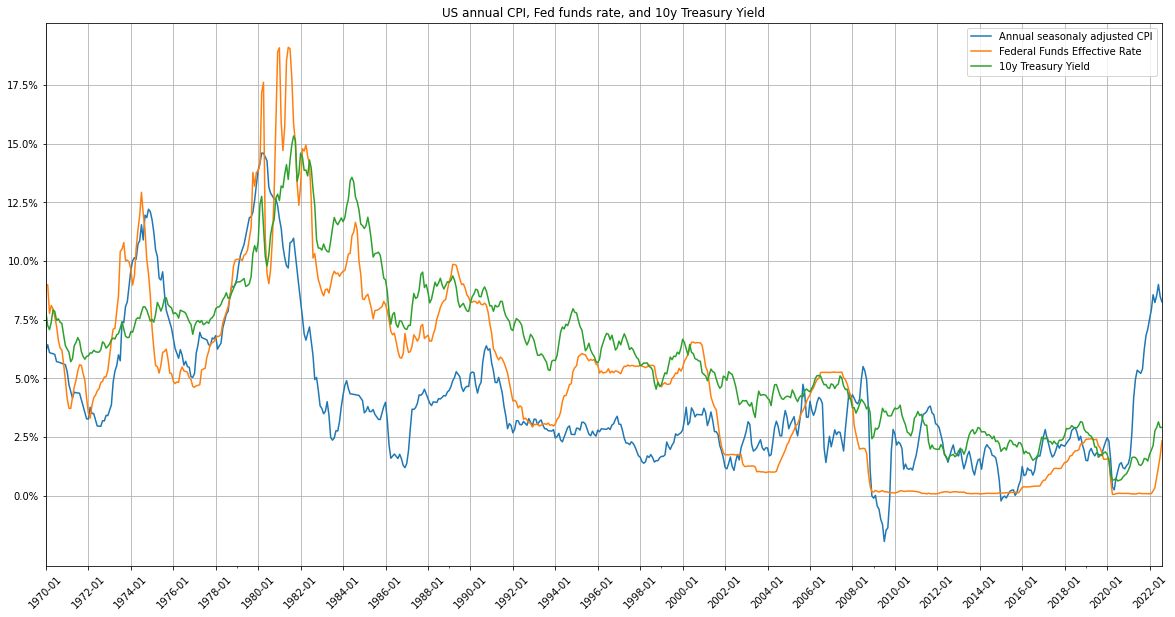

In [5]:
ax = fred_cpi_ffr.plot(figsize=(20,10), grid=True, title='US annual CPI, Fed funds rate, and 10y Treasury Yield',
                       xticks=fred_cpi_ffr.index[::24], xlabel='', rot=45, yticks=np.arange(0, 20, 2.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_cpi_ffr.index[::24])))

### Analyzing US Treasury Curve and US Annual Inflation Expectations
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `DGS1MO` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3MO` &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS6MO` &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS2` &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS3` &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS5` &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS7` &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS30` &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency)
* `T5YIEM` &mdash; 5-Year Breakeven Inflation Rate (monthly frequency)
* `T7YIEM` &mdash; 7-Year Breakeven Inflation Rate (monthly frequency)
* `T10YIEM` &mdash; 10-Year Breakeven Inflation Rate (monthly frequency)
* `T20YIEM` &mdash; 20-Year Breakeven Inflation Rate (monthly frequency)
* `T30YIEM` &mdash; 30-Year Breakeven Inflation Rate (monthly frequency)

For calculating inflation expectations I use breakeven inflation rates. Given that the breakeven inflation rate for N-Year maturity is calculated by subtracting the yield on the Treasury Inflation-Protected Securities of N-Year maturity from the yield on the ordinary Treasurt Bond of the same N-Year maturity, it gives an indication of what the Financial Markets expect the inflation to be on average over the N-Year perood. For inflation expectaion of maturity 0, I take the last published seasonally adjusted CPI. Unfortunately breakeven inflation rates are only available for maturities of 5 year and longer.

It's important to take day count conventions and compounding frequencies into account:
* Constant Maturity Treasury Seecurities (CMT) yields are provided with semiannual compounding frequencies using the actual/actual day count convention, as explained [here](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions)
* Federal Funds Effective Rate, on the other hand, is provied using the actual/360 day count convention with annual compounding.

In this notebook I convert all rates to actual/actual day count with annual compounding frequency, whereby obtaining Annual Percentage Yields (APY).

#### Retrieving and preparing data for US Treasury Yield Curve construction

In [6]:
report_start = date.fromisoformat('2012-01-01')

# Treasury yield curve
data = web.get_data_fred(['FEDFUNDS', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30'], report_start, report_end)
data.dropna(inplace=True)

# The following data series are only provided with daily frequences, hence we need to downsample them
# by taking their mean value over a given month and rounding to two decimal points (that's how values
# in series with monthly frequencies are calculated)
data2 = web.get_data_fred(['DGS1MO', 'DGS3MO', 'DGS6MO'], report_start, report_end)
data2 = data2.resample('MS').mean().round(2)

data = pd.concat([data, data2], axis=1).dropna()

# Rearranging columns
data = data[['FEDFUNDS', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30']]

# Renaming to reflect quarterly frequencies in the columns that used to have monthly frequencies
data.rename(columns={'DGS1MO': 'GS1MO', 'DGS3MO': 'GS3MO', 'DGS6MO': 'GS6MO'}, inplace=True)

# Converting to decimal fractions, i.e. 1% is 0.01
data /= 100.

# Converting the Fed Funds Rate to actual/actual
leap_year_cond = data.FEDFUNDS.index.year % 4 == 0 & ((data.FEDFUNDS.index.year % 100 != 0) | (data.FEDFUNDS.index.year % 400 == 0))
data.FEDFUNDS[leap_year_cond] *= 366. / 360
data.FEDFUNDS[np.invert(leap_year_cond)] *= 365. / 360

# Converting all CMT Yields to APY
data.iloc[:, 1:] = (data.iloc[:, 1:]/2 + 1)**2 - 1

In [7]:
data

,FEDFUNDS,GS1MO,GS3MO,GS6MO,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30
DATE,,,,,,,,,,,,
2012-01-01,0.000813,0.000200,0.000300,0.000700,0.001200,0.002401,0.003603,0.008418,0.013848,0.019797,0.027182,0.030530
2012-02-01,0.001017,0.000600,0.000900,0.001200,0.001601,0.002802,0.003804,0.008317,0.013747,0.019797,0.027689,0.031342
2012-03-01,0.001322,0.000600,0.000800,0.001400,0.001901,0.003403,0.005107,0.010226,0.015661,0.021818,0.029616,0.033069
2012-04-01,0.001423,0.000700,0.000800,0.001400,0.001801,0.002902,0.004305,0.008920,0.014351,0.020605,0.028399,0.032053
2012-05-01,0.001627,0.000700,0.000900,0.001501,0.001901,0.002902,0.003904,0.007614,0.012137,0.018081,0.025460,0.029515
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,0.003346,0.003102,0.007614,0.012640,0.018989,0.025561,0.027385,0.027993,0.028196,0.027689,0.030124,0.028297
2022-05-01,0.007807,0.005808,0.009925,0.014956,0.020706,0.026372,0.028095,0.028906,0.029413,0.029210,0.032866,0.030936
2022-06-01,0.012268,0.010628,0.015459,0.021818,0.026676,0.030225,0.031748,0.032154,0.032358,0.031646,0.035103,0.032764


#### Retrieving data for inflation expectaions curve construction
Similarly to the yield curve construction, some adjustments need to be made first.

* Break even inflation rates based on Constant Maturity Treasury Seecurities (CMT) yields are provided with semiannual compounding frequencies using the actual/actual day count convention, as explained [here](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions)
* The way CPI is calculated results in annual compounding with an actual/actual day count convention.

As a result we need to adjust breakeven inflation rates to annual compounding.

In [8]:
# Inflation expectaions as given by breakeven inflation rates
data_infl = web.get_data_fred(['T5YIEM', 'T7YIEM', 'T10YIEM', 'T20YIEM', 'T30YIEM'], report_start, report_end)
data_infl.dropna(inplace=True)

cpi = fred_cpi_ffr[['Annual seasonaly adjusted CPI']].loc['2012':]

# Converting to decimal fractions, i.e. 1% is 0.01
data_infl /= 100.
cpi /= 100.

# Converting all CMT-based Breakeven rates to APY
data_infl = (data_infl/2 + 1)**2 - 1

# Adding CPI
data_infl = pd.concat([cpi, data_infl], axis=1).dropna()

In [9]:
data_infl

,Annual seasonaly adjusted CPI,T5YIEM,T7YIEM,T10YIEM,T20YIEM,T30YIEM
DATE,,,,,,
2012-01-01,0.030088,0.017677,0.019393,0.020908,0.022020,0.023031
2012-02-01,0.028982,0.019494,0.020706,0.022323,0.023132,0.024043
2012-03-01,0.025829,0.020605,0.021413,0.023233,0.023942,0.024245
2012-04-01,0.022732,0.019595,0.020908,0.022728,0.023335,0.024043
2012-05-01,0.017379,0.018888,0.020100,0.021514,0.021009,0.022627
...,...,...,...,...,...,...
2022-04-01,0.082241,0.033476,0.031443,0.029007,0.028804,0.025663
2022-05-01,0.085164,0.030530,0.029007,0.027081,0.028095,0.024853
2022-06-01,0.089952,0.029109,0.028095,0.026372,0.027993,0.024853


#### Constructing US Treasury Yield and Inflation expectations curves

In [10]:
date = data.index[-1].date()
date_1_mth_ago = date + relativedelta(months=-1)
date_1_year_ago = date + relativedelta(years=-1)
date_2_years_ago = date + relativedelta(years=-2)
date_5_years_ago = date + relativedelta(years=-5)
date_10_years_ago = date + relativedelta(years=-10)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Unfortunately fewer curve points for US Inflation expectations
offsets_infl = [relativedelta(), relativedelta(years=+5), relativedelta(years=+7),
                relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Define US Treasury yield curves
curve = curves.YieldCurve(date, offsets, data[date:date+BDay()].to_numpy()[0,:])
curve_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets,
                                    data[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:])
curve_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets,
                                     data[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets,
                                      data[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets,
                                      data[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])
curve_10_years_ago = curves.YieldCurve(date_10_years_ago, offsets,
                                       data[date_10_years_ago:date_10_years_ago+BDay()].to_numpy()[0,:])

# Define US Inflation expectations curves
curve_infl = curves.YieldCurve(date, offsets_infl, data_infl[date:date+BDay()].to_numpy()[0,:])
curve_infl_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets_infl,
                                         data_infl[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:])
curve_infl_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets_infl,
                                          data_infl[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_infl_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets_infl,
                                          data_infl[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_infl_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets_infl,
                                          data_infl[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])

#### Visualizing current  US Treasury Yield and US Inflation Expectations Curves

In [11]:
curve_points = curve.get_curve_points(120)
curve_points_infl = curve_infl.get_curve_points(120)
curve_points_1_mth_ago = curve_1_mth_ago.get_curve_points(120)
curve_points_infl_1_mth_ago = curve_infl_1_mth_ago.get_curve_points(120)
curve_points.rename('US Treasury Yield', inplace=True)
curve_points_infl.rename('US Annual Inflation Expectations', inplace=True)
curve_points_1_mth_ago.rename('US Treasury Yield (1 month prior)', inplace=True)
curve_points_infl_1_mth_ago.rename('US Annual Inflation Expectations (1 month prior)', inplace=True)

# Replacing indices for sake of better visualization
curve_points_1_mth_ago = curve_points_1_mth_ago.set_axis(curve_points.index)
curve_points_infl_1_mth_ago = curve_points_infl_1_mth_ago.set_axis(curve_points_infl.index)
df = pd.concat([curve_points, curve_points_infl, curve_points_1_mth_ago, curve_points_infl_1_mth_ago], axis=1)

In [12]:
df

,US Treasury Yield,US Annual Inflation Expectations,US Treasury Yield (1 month prior),US Annual Inflation Expectations (1 month prior)
2022-08-01,0.023624,0.082492,0.017033,0.084821
2022-11-01,0.027392,0.076247,0.022986,0.078145
2023-02-01,0.031752,0.070482,0.028870,0.071987
2023-05-04,0.032992,0.065176,0.030793,0.066325
2023-08-04,0.033065,0.060311,0.030420,0.061139
...,...,...,...,...
2051-07-29,0.032919,0.024500,0.032665,0.023970
2051-10-29,0.032608,0.024162,0.032342,0.023595
2052-01-29,0.032276,0.023806,0.031997,0.023195
2052-04-30,0.031922,0.023429,0.031630,0.022772


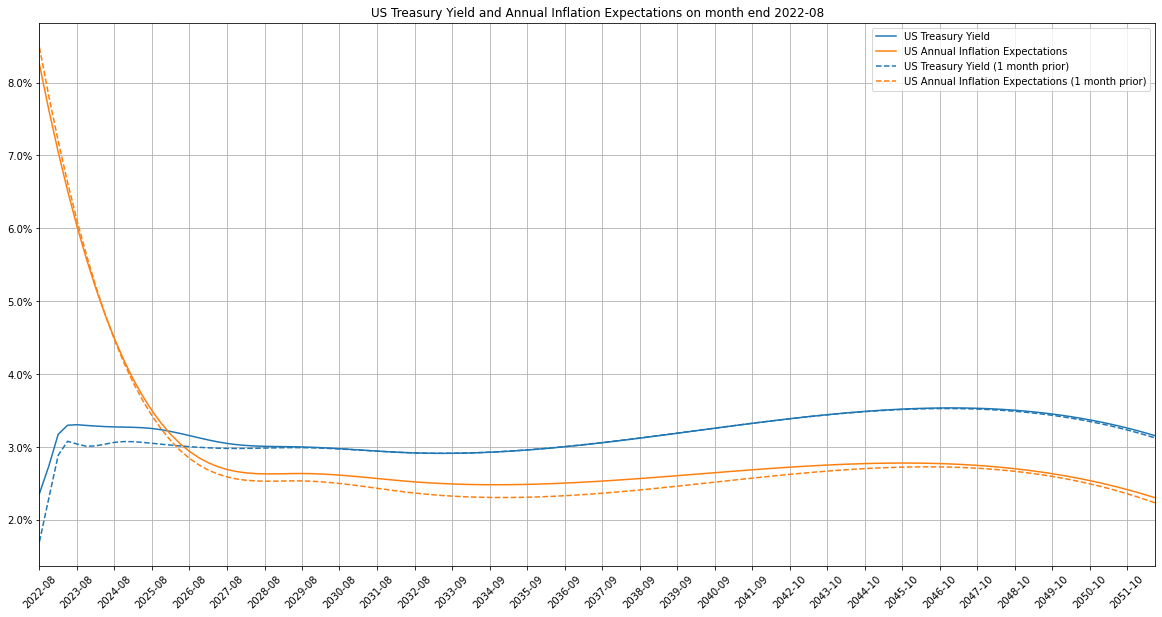

In [13]:
ax = df.iloc[:,:2].plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]), xticks=df.index[::4], xlabel='', rot=45)
df.iloc[:,2:].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df.index[::4])))

#### Visualizing US Treasury Yield and US Inflation Expectations Curves as of 1, 2, and 5 years ago 

In [14]:
curve_points_1_year_ago = curve_1_year_ago.get_curve_points(120)
curve_points_infl_1_year_ago = curve_infl_1_year_ago.get_curve_points(120)
curve_points_1_year_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_1_year_ago.rename('US Annual Inflation Expectations', inplace=True)
df_1_year_ago = pd.concat([curve_points_1_year_ago, curve_points_infl_1_year_ago], axis=1)

In [15]:
curve_points_2_years_ago = curve_2_years_ago.get_curve_points(120)
curve_points_infl_2_years_ago = curve_infl_2_years_ago.get_curve_points(120)
curve_points_2_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_2_years_ago.rename('US Annual Inflation Expectations', inplace=True)
df_2_years_ago = pd.concat([curve_points_2_years_ago, curve_points_infl_2_years_ago], axis=1)

In [16]:
curve_points_5_years_ago = curve_5_years_ago.get_curve_points(120)
curve_points_infl_5_years_ago = curve_infl_5_years_ago.get_curve_points(120)
curve_points_5_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_5_years_ago.rename('US Annual Inflation Expectations', inplace=True)
df_5_years_ago = pd.concat([curve_points_5_years_ago, curve_points_infl_5_years_ago], axis=1)

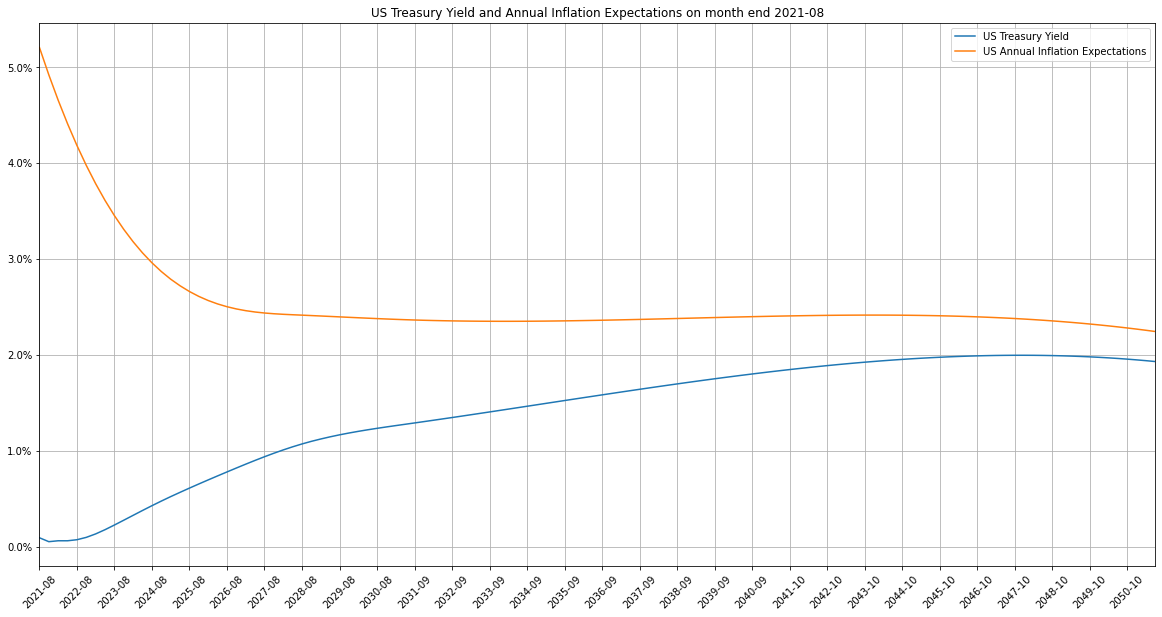

In [17]:
ax = df_1_year_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_1_year_ago.strftime('%Y-%m'),
             xlim=(df_1_year_ago.index[0], df_1_year_ago.index[-1]),
             xticks=df_1_year_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_1_year_ago.index[::4])))

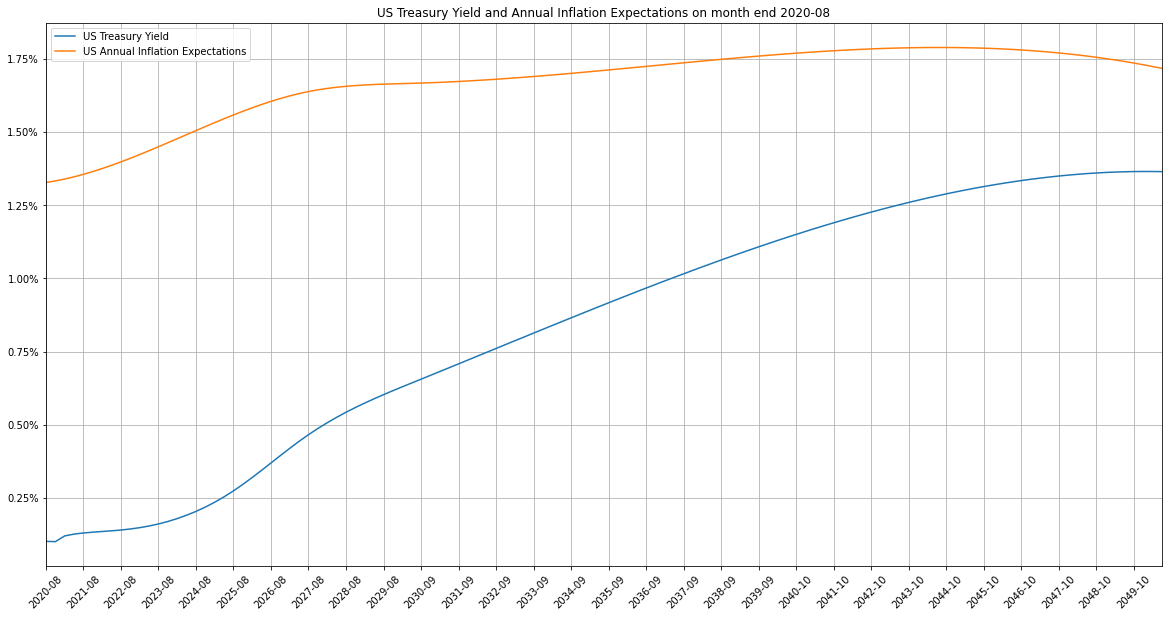

In [18]:
ax = df_2_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_2_years_ago.strftime('%Y-%m'),
             xlim=(df_2_years_ago.index[0], df_2_years_ago.index[-1]),
             xticks=df_2_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_2_years_ago.index[::4])))

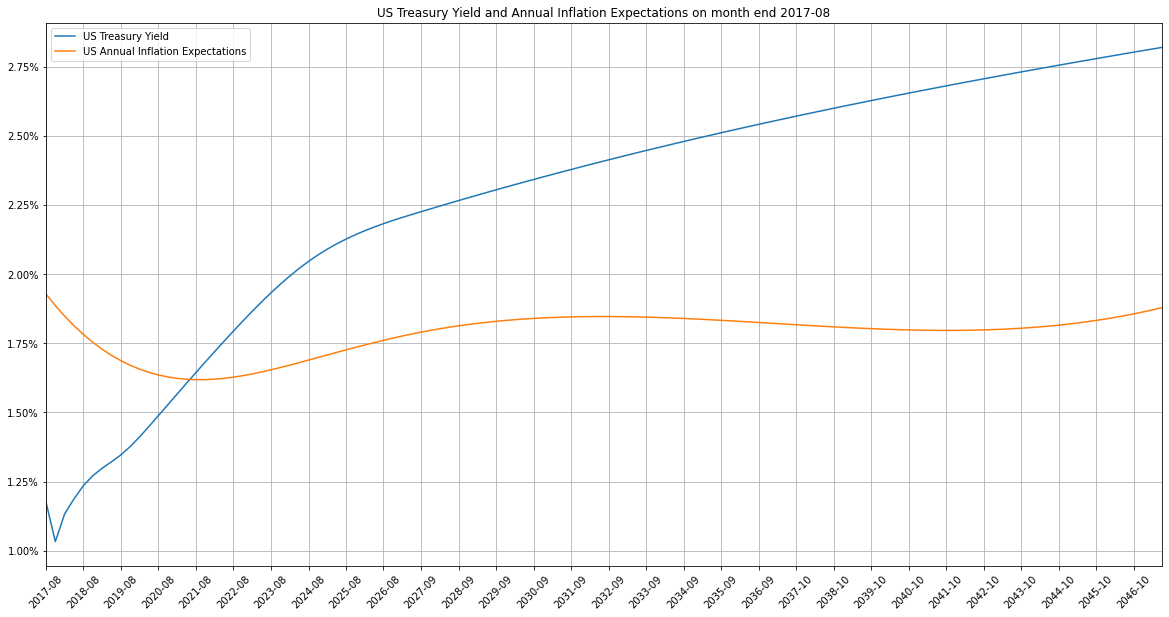

In [19]:
ax = df_5_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Inflation Expectations on month end ' + date_5_years_ago.strftime('%Y-%m'),
             xlim=(df_5_years_ago.index[0], df_5_years_ago.index[-1]),
             xticks=df_5_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df_5_years_ago.index[::4])))

### Correlations changes in the Fed Funds Effective Rate and CPI
It's interesting to look at how tighter monetary policy as expressed by the Federal Funds Effective Rate correlates with CPI. Since such dependencies play out over a few quarters, therefore I downsample to quarterly frequencies.

* **Fed Funds Effective Rate and CPI**: No immediate sizable correlation, however it becomes noticable after 2 years &mdash; i.e. Fed Funds Rate increases in a given quarter correlate negatively with CPI in about 2 years. Still, the correlation is rather small &mdash; about -8% over the entire time period of 1955-2022 and about -13% when I analyze the periods with bouts of high inflation 1955-1985. Nevertheless, the correlation between changes in the broad money supply M2 and CPI is much stronger &asymp; 55%, as you can see in [this notebook](./M2_PCE_and_CPI.ipynb).

In [20]:
report_start = date.fromisoformat('1954-07-01')

In [21]:
cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS'], report_start)

# Downsample to quarter start based on the value in the last month of the quarter
cpi_ffr = cpi_ffr.resample('QS').last()

# Convert to annual percentage changes
cpi_ffr.update(cpi_ffr.pct_change())

cpi_ffr = cpi_ffr['1955':]

Very small positive immediate correlation.

In [22]:
cpi_ffr.corr()

,CPIAUCSL,FEDFUNDS
CPIAUCSL,1.00000,0.19139
FEDFUNDS,0.19139,1.00000


Let's see how it changes as we look at correlation between tightening of the Fed Funds Rate and CPI in a few quarters later.

In [23]:
ffr = cpi_ffr.FEDFUNDS
cpi = cpi_ffr.CPIAUCSL

GRAPH_TITLE = 'Correlation between changes in Fed Funds Effective Rate and CPI over '

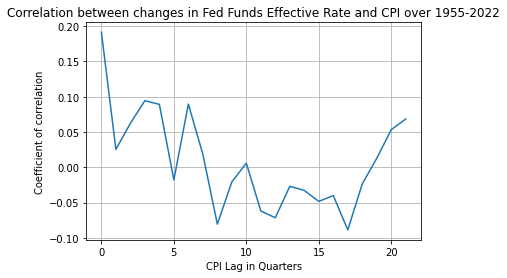

In [24]:
idx = pd.Index(range(22), name='CPI Lag in Quarters')
effect_of_monetary_tightning = pd.Series(idx.map(lambda lag: ffr.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_monetary_tightning.plot(grid=True, title=GRAPH_TITLE + '%d-%d' % (ffr.index[0].year, ffr.index[-1].year),
                                      ylabel='Coefficient of correlation')

Indeed, as expected, we see a negative correlation with a lag of about 2 years. However it's not very strong. Let's see if it's different if we limit the analysis to 1960-1986 period when we saw bouts of high inflation.

In [25]:
ffr_85 = cpi_ffr.FEDFUNDS[:'1986']
cpi_85 = cpi_ffr.CPIAUCSL[:'1986']

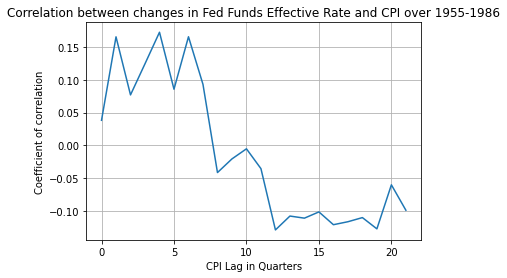

In [26]:
effect_of_monetary_tightning = pd.Series(idx.map(lambda lag: ffr_85.corr(cpi_85.shift(-lag))), index=idx)
_ = effect_of_monetary_tightning.plot(grid=True, title=GRAPH_TITLE + '%d-%d' % (ffr_85.index[0].year, ffr_85.index[-1].year),
                                      ylabel='Coefficient of correlation')

A somewhat stronger correlation of about -13% as compared to -8% when I looked at the whole series of 1955-2022. Nevertheless, the correlation between changes in the broad money supply M2 and CPI is much stronger as you can see in [this notebook](./M2_PCE_and_CPI.ipynb).